In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [64]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,diff_equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraFixa)

In [3]:
with open('datasets\\Dados espaciais.bkp','rb') as file:
    y,dy=dill.load(file)

In [4]:
indice = np.arange(y.shape[0])
np.random.shuffle(indice)
data_x = y.astype('float64')[indice]
data_y = dy.astype('float64')[indice]

In [5]:
# Conjunto de dados de treino
train_x = data_x[:-20000]
train_y = data_y[:-20000]

# Conjunto de dados de validação
test_x = data_x[-20000:]
test_y = data_y[-20000:]

In [65]:
# Criando uma camada de Burgers que integra o WENO à rede neural
Δx=0.014388489208633115
Sim_layer = WENO_espacial(Δx,FronteiraFixa,diff_equation,WENO_JS)
WENO_network=tf.function(lambda u0, Δx:Sim_layer.DerivadaEspacial(u0,Δx, FronteiraFixa))

In [7]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([7], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, Sim_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['MSE'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')

In [8]:
# Treinando a rede neural
history=
Network.fit(
    train_x                           , # Dados de treino
    train_y                           , # Dados de treino
    validation_data = (test_x, test_y), # Dados de validação
    batch_size      = 1024            , # Tamanho do batch
    epochs          = 100             , # Número de epochs
    steps_per_epoch = 300             , # Número de batchs por epoch
    shuffle         = True              # Aleatorização dos batchs
)

# Batch: pacote de dados utilizados antes de uma atualização dos pesos da rede
# Epoch: rodada de treino da rede neural, em geral percorre todo o conjunto de dados

Epoch 1/100
300/300 [==============================] - 19s 38ms/step - loss: 25.2380 - MSE: 9619.6494 - val_loss: 24.0511 - val_MSE: 8419.2783
Epoch 2/100
300/300 [==============================] - 10s 34ms/step - loss: 24.3795 - MSE: 8986.7930 - val_loss: 23.7815 - val_MSE: 8381.3008
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 24.2259 - MSE: 8941.7598 - val_loss: 23.5528 - val_MSE: 8347.4092
Epoch 4/100
300/300 [==============================] - 10s 35ms/step - loss: 23.6064 - MSE: 8641.4277 - val_loss: 23.3806 - val_MSE: 8332.7031
Epoch 5/100
300/300 [==============================] - 10s 35ms/step - loss: 23.6639 - MSE: 8736.1182 - val_loss: 23.1826 - val_MSE: 8188.6289
Epoch 6/100
300/300 [==============================] - 11s 36ms/step - loss: 23.4282 - MSE: 8661.6924 - val_loss: 23.0753 - val_MSE: 8195.1562
Epoch 7/100
300/300 [==============================] - 11s 36ms/step - loss: 23.2549 - MSE: 8526.0400 - val_loss: 23.0106 - val_MSE: 8172.9897

In [ ]:
# Salvando os pesos treinados
Network.save_weights('Modelos treinados\\Modelo Rede espacial - 1')

In [ ]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede espacial - 1')

In [ ]:

# Função definida no artigo
f_test = lambda x: -(-tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres)))

In [27]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa
Δx_ref = 0.01
Δx = Δx_ref                                # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

full_U=tf.expand_dims(f_test(x),axis=0)

net_u   = WENO_network(full_U,Δx)

In [28]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

k=1

Δx = Δx_ref/k                              # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

full_U=tf.expand_dims(f_test(x),axis=0)

debug_u   = WENO_Z_ref(full_U,Δx)         # Previsão com o WENO-Z modificado pela rede neural
debug_u   = tf.gather(debug_u,np.arange(net_u.shape[-1])*k,axis=-1) 

In [29]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

k=4

Δx = Δx_ref/k                               # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

full_U=tf.expand_dims(f_test(x),axis=0)

ref_full   = tf.gather(WENO_Z_ref(full_U,Δx),np.arange(net_u.shape[-1])*k,axis=-1)             # Previsão com o WENO-Z modificado pela rede neural
ref_full   = tf.gather(ref_full,np.arange(net_u.shape[-1])*k,axis=-1) 

# Armazenando ambos os erros de previsão
error = tf.stack([net_u-ref_full,debug_u-ref_full],axis=0)
error = tf.squeeze(error)

In [31]:
# Calculando média dos erros de acordo com a norma L2, L1 ou L-inf

# Norma L2:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_sum(error**2, axis=-1)**0.5
#--------------------------------------------------------------------------------------
print('L2:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Norma L1:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_sum(tf.abs(error), axis=-1)
#--------------------------------------------------------------------------------------
print('L1:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Noma L-inf:
#-------------------------------------------------------------------------------------
desv_error = tf.math.reduce_max(tf.abs(error), axis=-1)
#--------------------------------------------------------------------------------------
print('L-inf:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())

L2:
[220.28060229 208.62306642]
1.0558784609549836


L1:
[662.31188272 656.02989096]
1.0095757706283115


L-inf:
[195.48070563 195.48070572]
0.999999999539954


In [60]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa
sizes=[10,50,100,200,500,1000]
error=[]
k=4
for i in sizes:
    print(i,end='\r')
    Δx_ref = 2/i
    Δx = Δx_ref                                # Distância espacial dos pontos na malha mais grossa utilizada
    x  = tf.range(-1, -0.5, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

    full_U=tf.expand_dims(f_test(x),axis=0)
    net_u   = WENO_Z_ref(full_U,Δx)

    Δx = Δx_ref/k                                # Distância espacial dos pontos na malha mais grossa utilizada
    x  = tf.range(-1, -0.5, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

    full_U=tf.expand_dims(f_test(x),axis=0)
    ref_u   = WENO_Z_ref(full_U,Δx)
    ref_u   = tf.gather(ref_u,np.arange(net_u.shape[-1])*k,axis=-1) 

    error.append(np.sum(np.abs(net_u-ref_u)))


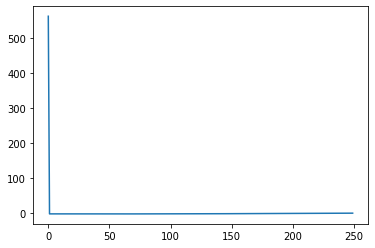

In [62]:
plt.plot(ref_u[0])

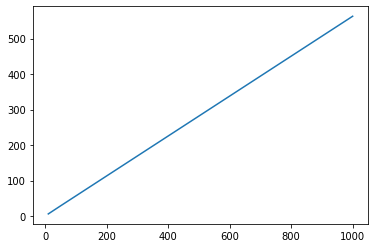

In [63]:
plt.plot(sizes,error)

In [52]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,diff_equation,WENO_JS)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraFixa)

In [ ]:
Δx_ref = 0.01

def f(x):
    return np.sin(np.pi*x)

def df(x):
    return np.pi*np.cos(np.pi*x)


In [ ]:
Δx1 = Δx_ref
x1  = np.arange(-1, 1, Δx1)
x1  = np.expand_dims(x1,0)
u1  = f(x1)
du1 = df(x1)
y1=WENO_Z_ref(u1, Δx1)

print(u1.shape)

In [ ]:
Δx2 = Δx_ref/2
x2  = np.arange(-1, 1, Δx2)
x2  = np.expand_dims(x2,0)
u2  = f(x2)
du2 = df(x2)
y2=WENO_Z_ref(u2, Δx2)

print(u2.shape)

In [ ]:
Δx3 = Δx_ref/4
x3  = np.arange(-1, 1, Δx3)
x3  = np.expand_dims(x3,0)
u3  = f(x3)
du3 = df(x3)
y3=WENO_Z_ref(u3, Δx3)

print(u3.shape)

In [ ]:
# Gerando os gráficos a partir de funções do matplotlib

print(np.sum(abs(y1 - y3[:,np.arange(y1.shape[1])*4]))/np.sum(abs(y2[:,np.arange(y1.shape[1])*2] - y3[:,np.arange(y1.shape[1])*4])))

In [ ]:
np.log(23.50615689222527)/np.log(2)